<a href="https://colab.research.google.com/github/samiriff/MLND-digit-recognition/blob/master/Copy_of_digit_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Learning Engineer Nanodegree
## Deep Learning
## Project: Build a Digit Recognition Program

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

----
## Step 1: Design and Test a Model Architecture
Design and implement a deep learning model that learns to recognize sequences of digits. Train the model using synthetic data generated by concatenating character images from [notMNIST](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html) or [MNIST](http://yann.lecun.com/exdb/mnist/). To produce a synthetic sequence of digits for testing, you can for example limit yourself to sequences up to five digits, and use five classifiers on top of your deep network. You would have to incorporate an additional ‘blank’ character to account for shorter number sequences.

There are various aspects to consider when thinking about this problem:
- Your model can be derived from a deep neural net or a convolutional network.
- You could experiment sharing or not the weights between the softmax classifiers.
- You can also use a recurrent network in your deep neural net to replace the classification layers and directly emit the sequence of digits one-at-a-time.

You can use ** Keras ** to implement your model. Read more at [keras.io](https://keras.io/).

Here is an example of a [published baseline model on this problem](http://static.googleusercontent.com/media/research.google.com/en//pubs/archive/42241.pdf). ([video](https://www.youtube.com/watch?v=vGPI_JvLoN0)). You are not expected to model your architecture precisely using this model nor get the same performance levels, but this is more to show an exampe of an approach used to solve this particular problem. We encourage you to try out different architectures for yourself and see what works best for you. Here is a useful [forum post](https://discussions.udacity.com/t/goodfellow-et-al-2013-architecture/202363) discussing the architecture as described in the paper and here is [another one](https://discussions.udacity.com/t/what-loss-function-to-use-for-multi-digit-svhn-training/176897) discussing the loss function.

### Implementation
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import Image

import struct
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D, Input
from keras.utils import np_utils, plot_model
from keras.optimizers import SGD
from keras.datasets import mnist
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import rmsprop, Adam, Adagrad, SGD

from google.colab import files

Using TensorFlow backend.


## MNIST

In [2]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

11493376/11490434 [==============================] - 0s 0us/step


((48000, 28, 28), (12000, 28, 28), (48000,), (12000,))

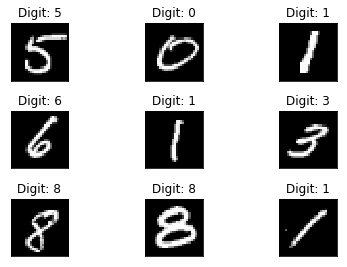

In [3]:
for i in range(9):
  plt.subplot(3,3,i+1)
  plt.tight_layout()
  plt.imshow(X_train[i], cmap='gray', interpolation='none')
  plt.title("Digit: {}".format(y_train[i]))
  plt.xticks([])
  plt.yticks([])

Text(0.5, 1.0, 'Pixel Value Distribution')

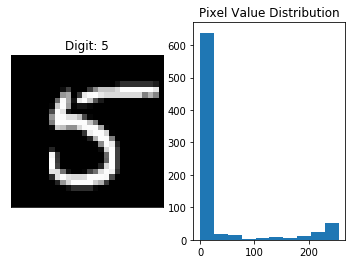

In [4]:
plt.subplot(1,2,1)
plt.imshow(X_train[0], cmap='gray', interpolation='none')
plt.title("Digit: {}".format(y_train[0]))
plt.xticks([])
plt.yticks([])
plt.subplot(1,2,2)
plt.hist(X_train[0].reshape(784))
plt.title("Pixel Value Distribution")

In [5]:
# let's print the shape before we reshape and normalize
print("X_train shape", X_train.shape)
print("y_train shape", y_train.shape)
print("X_test shape", X_test.shape)
print("y_test shape", y_test.shape)

# building the input vector from the 28x28 pixels
X_train_reshaped = X_train.reshape(X_train.shape[0], 784)
X_valid_reshaped = X_valid.reshape(X_valid.shape[0], 784)
X_test_reshaped = X_test.reshape(X_test.shape[0], 784)
X_train_reshaped = X_train_reshaped.astype('float32')
X_test_reshaped = X_test_reshaped.astype('float32')

# normalizing the data to help with the training
X_train_normalized = X_train_reshaped / 255
X_valid_normalized = X_valid_reshaped / 255
X_test_normalized = X_test_reshaped / 255

# print the final input shape ready for training
print("Train matrix shape", X_train_normalized.shape)
print("Validation matrix shape", X_valid_normalized.shape)
print("Test matrix shape", X_test_normalized.shape)

X_train shape (48000, 28, 28)
y_train shape (48000,)
X_test shape (10000, 28, 28)
y_test shape (10000,)
Train matrix shape (48000, 784)
Validation matrix shape (12000, 784)
Test matrix shape (10000, 784)


In [6]:
print(np.unique(y_train, return_counts=True))

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8), array([4748, 5420, 4784, 4912, 4666, 4317, 4741, 4966, 4691, 4755]))


In [7]:
# one-hot encoding using keras' numpy-related utilities
n_classes = 10
print("Shape before one-hot encoding: ", y_train.shape)
y_train_one_hot = np_utils.to_categorical(y_train, n_classes)
y_valid_one_hot = np_utils.to_categorical(y_valid, n_classes)
y_test_one_hot = np_utils.to_categorical(y_test, n_classes)
print("Shape after one-hot encoding: ", y_train_one_hot.shape)

Shape before one-hot encoding:  (48000,)
Shape after one-hot encoding:  (48000, 10)


### Fully-Connected Neural Network

In [0]:
# building a linear stack of layers with the sequential model
model = Sequential()
model.add(Dense(784, input_shape=(784,)))
model.add(Activation('relu'))                            
model.add(Dropout(rate=0.2))

model.add(Dense(30))
model.add(Activation('relu'))
model.add(Dropout(rate=0.2))

model.add(Dense(10))
model.add(Activation('softmax'))

In [0]:
# compiling the sequential model
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

In [0]:
model.fit(X_train_normalized, y_train_one_hot,
          batch_size=128, epochs=20,
          validation_data=(X_valid_normalized, y_valid_one_hot))

Train on 48000 samples, validate on 12000 samples
Epoch 1/20
48000/48000 [==============================] - 2s 44us/step - loss: 0.3916 - acc: 0.8849 - val_loss: 0.1430 - val_acc: 0.9585
Epoch 2/20
48000/48000 [==============================] - 2s 35us/step - loss: 0.1631 - acc: 0.9524 - val_loss: 0.1090 - val_acc: 0.9668
Epoch 3/20
48000/48000 [==============================] - 2s 35us/step - loss: 0.1166 - acc: 0.9662 - val_loss: 0.0871 - val_acc: 0.9735
Epoch 4/20
48000/48000 [==============================] - 2s 35us/step - loss: 0.0929 - acc: 0.9721 - val_loss: 0.0778 - val_acc: 0.9772
Epoch 5/20
48000/48000 [==============================] - 2s 35us/step - loss: 0.0737 - acc: 0.9775 - val_loss: 0.0802 - val_acc: 0.9760
Epoch 6/20
48000/48000 [==============================] - 2s 35us/step - loss: 0.0627 - acc: 0.9805 - val_loss: 0.0722 - val_acc: 0.9787
Epoch 7/20
48000/48000 [==============================] - 2s 34us/step - loss: 0.0534 - acc: 0.9833 - val_loss: 0.0741 - val_acc

In [0]:
model.evaluate(X_test_normalized, y_test_one_hot)

10000/10000 [==============================] - 0s 37us/step


[0.08180263675286069, 0.9821]

In [0]:
preds = model.predict_classes(X_test_normalized)
preds

array([7, 2, 1, ..., 4, 5, 6])

In [0]:
y_test

array([7, 2, 1, ..., 4, 5, 6], dtype=uint8)

In [0]:
np.sum(preds == y_test), np.sum(preds != y_test)

(9821, 179)

### Multi-Output Fully Connected Neural Network

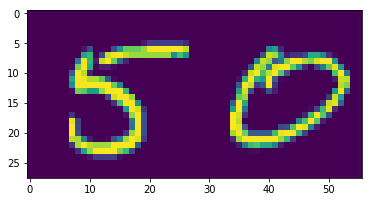

In [8]:
plt.imshow(np.concatenate([X_train[0], X_train[1]], axis=1))

In [9]:
X_train_normalized.shape, y_train_one_hot.shape

((48000, 784), (48000, 10))

3

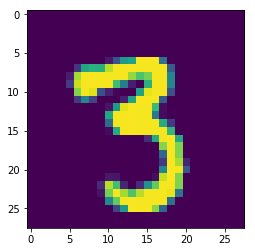

In [10]:
dummy_x, dummy_y = shuffle(X_train, y_train)
plt.imshow(dummy_x[0])
dummy_y[0]

In [0]:
def generator(samples, labels, batch_size=32):
    num_samples = len(samples)
    while 1: # Loop forever so the generator never terminates
        shuffled_samples, shuffled_labels = shuffle(samples, labels)
        for offset in range(0, num_samples, batch_size):
            batch_samples = shuffled_samples[offset:offset+batch_size]
            batch_labels = shuffled_labels[offset:offset+batch_size]
            batch_samples, batch_labels_1, batch_labels_2 = shuffle(batch_samples, batch_labels, batch_labels)
            yield (batch_samples, {
                'output_1': batch_labels_1,
                'output_2': batch_labels_2
            })

(8, 8)

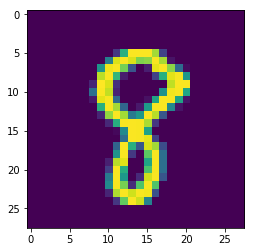

In [12]:
dummy_x, dummy_output = next(generator(X_train, y_train))
plt.imshow(dummy_x[0])
dummy_output['output_1'][0], dummy_output['output_2'][0]

In [13]:
np.concatenate([X_train_normalized[0], X_train_normalized[1]]).shape

(1568,)

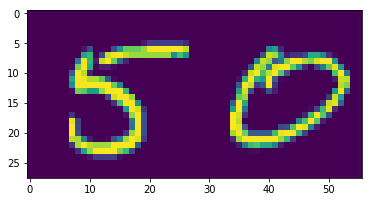

In [14]:
plt.imshow(np.concatenate([X_train_normalized[0].reshape(28, 28), X_train_normalized[1].reshape(28, 28)], axis=1))

In [15]:
np.concatenate([X_train_normalized[0].reshape(28, 28), X_train_normalized[1].reshape(28, 28)], axis=1).reshape(1568, ).shape

(1568,)

In [0]:
def get_concatenated_samples(samples, labels):
  concatenated_samples = []
  concatenated_labels_1 = []
  concatenated_labels_2 = []
  num_samples = len(samples)
  for i in range(0, num_samples-1):
    #concatenated_sample = np.concatenate([samples[i], samples[i+1]])
    concatenated_sample = np.concatenate([samples[i].reshape(28, 28), samples[i+1].reshape(28, 28)], axis=1).reshape(1568, )
    concatenated_samples.append(concatenated_sample)
    
    concatenated_labels_1.append(labels[i])
    concatenated_labels_2.append(labels[i+1])
    
  return np.array(concatenated_samples), np.array(concatenated_labels_1), np.array(concatenated_labels_2)

In [17]:
get_concatenated_samples(X_train_normalized[0:30], y_train_one_hot[0:30])[2].shape

(29, 10)

In [0]:
def concatenated_generator(samples, labels, batch_size=32, is_shuffle_on=True):
    num_samples = len(samples)
    while 1: # Loop forever so the generator never terminates
        if is_shuffle_on:
          shuffled_samples, shuffled_labels = shuffle(samples, labels)
        else:
          shuffled_samples, shuffled_labels = samples, labels
        for offset in range(0, num_samples, batch_size):
            batch_samples = shuffled_samples[offset:offset+batch_size]
            batch_labels = shuffled_labels[offset:offset+batch_size]
            batch_samples_concat, batch_labels_1, batch_labels_2 = get_concatenated_samples(batch_samples, batch_labels)
            if is_shuffle_on:
              batch_samples_concat, batch_labels_1, batch_labels_2 = shuffle(batch_samples_concat, batch_labels_1, batch_labels_2)
            yield (batch_samples_concat, {
                'output_1': batch_labels_1,
                'output_2': batch_labels_2
            })

In [93]:
next(concatenated_generator(X_train_normalized, y_train_one_hot))[1]['output_1'].shape

(31, 10)

In [19]:
inputs = Input(shape=(1568, ))
x = Dense(784, activation='relu')(inputs)
x = Dropout(rate=0.2)(x)
x = Dense(30, activation='relu')(x)
x = Dropout(rate=0.2)(x)
output_1 = Dense(10, activation='softmax', name='output_1')(x)
output_2 = Dense(10, activation='softmax', name='output_2')(x)

model = Model(input=inputs, outputs=[output_1, output_2])
model.compile(optimizer='rmsprop', loss={
    'output_1': 'categorical_crossentropy',
    'output_2': 'categorical_crossentropy'
}, metrics=['accuracy'])

batch_size = 128
model.fit_generator(
    concatenated_generator(X_train_normalized, y_train_one_hot, batch_size), 
    steps_per_epoch=len(X_train_normalized) // batch_size, 
    epochs=10
)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=[<tf.Tenso..., inputs=Tensor("in...)`
  if __name__ == '__main__':


Instructions for updating:
Use tf.cast instead.
Epoch 1/10
375/375 [==============================] - 5s 14ms/step - loss: 1.6649 - output_1_loss: 0.8262 - output_2_loss: 0.8388 - output_1_acc: 0.7281 - output_2_acc: 0.7290
Epoch 2/10
375/375 [==============================] - 3s 7ms/step - loss: 0.8191 - output_1_loss: 0.4172 - output_2_loss: 0.4019 - output_1_acc: 0.8728 - output_2_acc: 0.8775
Epoch 3/10
375/375 [==============================] - 3s 7ms/step - loss: 0.6305 - output_1_loss: 0.3213 - output_2_loss: 0.3093 - output_1_acc: 0.9047 - output_2_acc: 0.9080
Epoch 4/10
375/375 [==============================] - 3s 7ms/step - loss: 0.5248 - output_1_loss: 0.2654 - output_2_loss: 0.2594 - output_1_acc: 0.9228 - output_2_acc: 0.9239
Epoch 5/10
375/375 [==============================] - 3s 7ms/step - loss: 0.4628 - output_1_loss: 0.2355 - output_2_loss: 0.2273 - output_1_acc: 0.9322 - output_2_acc: 0.9329
Epoch 6/10
375/375 [==============================] - 3s 7ms/step - loss: 0.

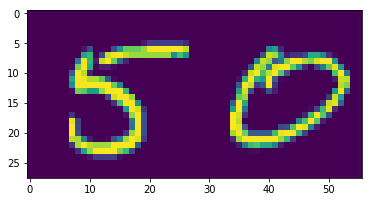

In [20]:
plt.imshow(next(concatenated_generator(X_train_normalized, y_train_one_hot, is_shuffle_on=False))[0].reshape(31, 28, 56)[0])

In [21]:
next(concatenated_generator(X_train_normalized, y_train_one_hot, is_shuffle_on=False))[1]['output_1'][0]

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.], dtype=float32)

In [0]:
gen = concatenated_generator(X_valid_normalized, y_valid_one_hot, batch_size=2, is_shuffle_on=False)
i = -1

In [43]:
dummy_sample, dummy_label_map = next(gen)
i += 1
dummy_sample.shape, i

((1, 1568), 3)

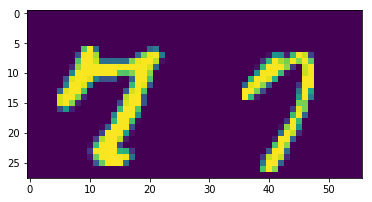

In [44]:
plt.imshow(dummy_sample.reshape(28, 56))

In [45]:
np.argmax(dummy_label_map['output_1']), np.argmax(dummy_label_map['output_2'])

(7, 7)

In [64]:
pred = model.predict(dummy_sample)
np.argmax(pred[0]), np.argmax(pred[1]), pred[0][0][np.argmax(pred[0])], pred[1][0][np.argmax(pred[1])]

(7, 7, 0.9997855, 0.99998546)

In [0]:
preds = model.predict_generator( 
    concatenated_generator(X_valid_normalized, y_valid_one_hot, 2, False), 
    steps=len(X_valid_normalized)
)

In [47]:
np.argmax(preds[0][i]), np.argmax(preds[1][i])

(7, 7)

In [111]:
preds[0][0]

array([5.9718576e-07, 3.2135662e-11, 5.3932354e-07, 2.4401186e-06,
       2.2138398e-09, 1.9525379e-08, 6.7208834e-12, 9.9967384e-01,
       2.9687419e-08, 3.2251215e-04], dtype=float32)

In [137]:
model.evaluate_generator(
    concatenated_generator(X_valid_normalized, y_valid_one_hot, batch_size, False),
    steps=len(X_valid_normalized) // batch_size
)

[0.21670776974129421,
 0.11075690404702258,
 0.10595086538383076,
 0.9703666202483638,
 0.9713826224368106]

In [138]:
model.metrics_names

['loss', 'output_1_loss', 'output_2_loss', 'output_1_acc', 'output_2_acc']

In [0]:
inputs = Input(shape=(784, ))
x = Dense(784, activation='relu')(inputs)
x = Dropout(rate=0.2)(x)
x = Dense(30, activation='relu')(x)
x = Dropout(rate=0.2)(x)
output_1 = Dense(10, activation='softmax')(x)
output_2 = Dense(10, activation='softmax')(x)

model = Model(input=inputs, outputs=[output_1, output_2])
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train_normalized, [y_train_one_hot, y_train_one_hot])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=[<tf.Tenso..., inputs=Tensor("in...)`
Exception ignored in: <generator object get_generator at 0x7f24a8e3faf0>
RuntimeError: generator ignored GeneratorExit
Exception ignored in: <generator object get_generator_multi_output at 0x7f24a92ea830>
RuntimeError: generator ignored GeneratorExit


Epoch 1/1
48000/48000 [==============================] - 8s 161us/step - loss: 0.6971 - dense_32_loss: 0.3525 - dense_33_loss: 0.3446 - dense_32_acc: 0.8980 - dense_33_acc: 0.9003


In [191]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_24 (InputLayer)           (None, 1568)         0                                            
__________________________________________________________________________________________________
dense_56 (Dense)                (None, 784)          1230096     input_24[0][0]                   
__________________________________________________________________________________________________
dropout_48 (Dropout)            (None, 784)          0           dense_56[0][0]                   
__________________________________________________________________________________________________
dense_57 (Dense)                (None, 30)           23550       dropout_48[0][0]                 
__________________________________________________________________________________________________
dropout_49

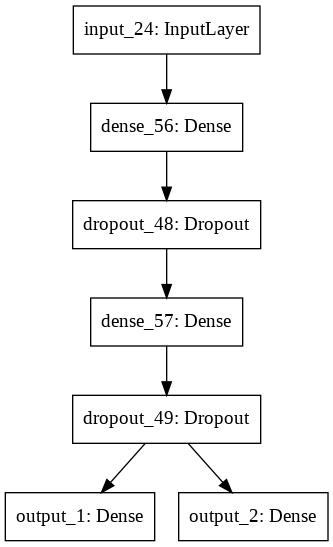

In [192]:
plot_model(model)
Image(filename='model.png') 

## notMNIST

In [0]:
!wget http://yaroslavvb.com/upload/notMNIST/notMNIST_small.tar.gz

--2019-04-18 04:30:39--  http://yaroslavvb.com/upload/notMNIST/notMNIST_small.tar.gz
Resolving yaroslavvb.com (yaroslavvb.com)... 129.121.4.193
Connecting to yaroslavvb.com (yaroslavvb.com)|129.121.4.193|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8458043 (8.1M) [application/x-gzip]
Saving to: ‘notMNIST_small.tar.gz’

notMNIST_small.tar. 100%[===================>]   8.07M  23.3MB/s    in 0.3s    

2019-04-18 04:30:40 (23.3 MB/s) - ‘notMNIST_small.tar.gz’ saved [8458043/8458043]



In [0]:
!tar -xzf notMNIST_small.tar.gz

In [0]:
!ls -l notMNIST_small/

total 1144
drwxrwxr-x 2 133040 5000 118784 Aug  9  2011 A
drwxrwxr-x 2 133040 5000 118784 Aug  9  2011 B
drwxrwxr-x 2 133040 5000 118784 Aug  9  2011 C
drwxrwxr-x 2 133040 5000 118784 Aug  9  2011 D
drwxrwxr-x 2 133040 5000 118784 Aug  9  2011 E
drwxrwxr-x 2 133040 5000 118784 Aug  9  2011 F
drwxrwxr-x 2 133040 5000 114688 Aug  9  2011 G
drwxrwxr-x 2 133040 5000 114688 Aug  9  2011 H
drwxrwxr-x 2 133040 5000 114688 Aug  9  2011 I
drwxrwxr-x 2 133040 5000 114688 Aug  9  2011 J


In [0]:
train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.1, horizontal_flip=True, validation_split=0.2)
image_width, image_height = 32, 32

In [0]:
train_generator = train_datagen.flow_from_directory(
    directory=r'./notMNIST_small/', 
    target_size=(image_width, image_height),
    color_mode='rgb', 
    batch_size=32,
    class_mode='categorical',
    shuffle=True,
    seed=42,
    subset='training'
)

Found 14986 images belonging to 10 classes.


In [0]:
validation_generator = train_datagen.flow_from_directory(
    directory=r'./notMNIST_small/',
    target_size=(image_width, image_height),
    color_mode='rgb',
    batch_size=32,
    class_mode='categorical',
    shuffle=True,
    seed=42,
    subset='validation'
)

Found 3740 images belonging to 10 classes.


In [0]:
evaluation_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
evaluation_generator = evaluation_datagen.flow_from_directory(
    directory=r'./notMNIST_small/',
    target_size=(image_width, image_height),
    color_mode='rgb',
    batch_size=32,
    class_mode='categorical',
)

Found 18726 images belonging to 10 classes.


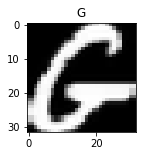

In [0]:
item = next(train_generator)
plt.figure(figsize=(15, 2))
plt.title(chr(ord('A') + np.argmax(item[1][0])))
plt.imshow(item[0][0])

In [0]:
step_size_train = train_generator.n // train_generator.batch_size
step_size_valid = validation_generator.n // validation_generator.batch_size
step_size_evaluation = evaluation_generator.n // evaluation_generator.batch_size
step_size_train, step_size_valid, step_size_evaluation

(468, 116, 585)

In [0]:
def get_generator(generator):
  global invalid_img_count
  while True:
    try:
      data, labels = next(generator)
      yield data, labels
    except:
      invalid_img_count += 1
      pass

In [0]:
def get_label(maxIdx):
  return chr(ord('A') + maxIdx)

In [0]:
num_classes = 10

### Fully-Connected Model

In [0]:
model = Sequential()
model.add(Dense(30, input_shape=(32, 32, 3)))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(30, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

In [0]:
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 32, 32, 30)        120       
_________________________________________________________________
activation_4 (Activation)    (None, 32, 32, 30)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 30720)             0         
_________________________________________________________________
dense_11 (Dense)             (None, 30)                921630    
_________________________________________________________________
dense_12 (Dense)             (None, 10)                310       
Total params: 922,060
Trainable params: 922,060
Non-trainable params: 0
_________________________________________________________________


In [0]:
invalid_img_count = 0
model.fit_generator(
    generator=get_generator(train_generator),
    steps_per_epoch=step_size_train,
    validation_data=get_generator(validation_generator),
    validation_steps=step_size_valid,
    epochs=10
)

Epoch 1/10
468/468 [==============================] - 26s 56ms/step - loss: 0.9737 - acc: 0.7127 - val_loss: 0.7902 - val_acc: 0.7915
Epoch 2/10
468/468 [==============================] - 25s 53ms/step - loss: 0.7312 - acc: 0.7977 - val_loss: 0.6928 - val_acc: 0.8109
Epoch 3/10
468/468 [==============================] - 25s 54ms/step - loss: 0.6870 - acc: 0.8091 - val_loss: 0.6128 - val_acc: 0.8328
Epoch 4/10
468/468 [==============================] - 24s 52ms/step - loss: 0.6568 - acc: 0.8187 - val_loss: 0.6025 - val_acc: 0.8412
Epoch 5/10
468/468 [==============================] - 24s 52ms/step - loss: 0.6503 - acc: 0.8208 - val_loss: 0.5623 - val_acc: 0.8474
Epoch 6/10
468/468 [==============================] - 25s 54ms/step - loss: 0.6281 - acc: 0.8231 - val_loss: 0.5817 - val_acc: 0.8487
Epoch 7/10
468/468 [==============================] - 25s 53ms/step - loss: 0.6129 - acc: 0.8256 - val_loss: 0.5479 - val_acc: 0.8584
Epoch 8/10
468/468 [==============================] - 24s 51ms

Exception ignored in: <generator object get_generator at 0x7f47fbe8b9e8>
RuntimeError: generator ignored GeneratorExit
Exception ignored in: <generator object get_generator at 0x7f47fbe8bb48>
RuntimeError: generator ignored GeneratorExit


In [0]:
invalid_img_count

22

In [0]:
model.evaluate_generator(get_generator(validation_generator), step_size_valid)

Exception ignored in: <generator object get_generator at 0x7f47ff883e60>
RuntimeError: generator ignored GeneratorExit


[0.5401071488792971, 0.8503236244668724]

In [0]:
model.metrics_names

['loss', 'acc']

In [0]:
plot_model(model)

In [0]:
files.download('model.png') 

### CNN

In [0]:
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same', input_shape=(image_width, image_height, 3)))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(rate=0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_18 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 30, 30, 32)        9248      
_________________________________________________________________
activation_19 (Activation)   (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 15, 15, 64)        18496     
__________

In [0]:
optimizer = Adam(lr=0.001)

In [0]:
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [0]:
invalid_image_count = 0
model.fit_generator(
    generator=get_generator(train_generator),
    steps_per_epoch=step_size_train,
    validation_data=get_generator(validation_generator),
    validation_steps=step_size_valid,
    epochs=10
)

Epoch 1/10
468/468 [==============================] - 25s 53ms/step - loss: 0.7208 - acc: 0.7800 - val_loss: 0.3304 - val_acc: 0.9030
Epoch 2/10
468/468 [==============================] - 24s 51ms/step - loss: 0.3997 - acc: 0.8810 - val_loss: 0.2818 - val_acc: 0.9194
Epoch 3/10
468/468 [==============================] - 25s 54ms/step - loss: 0.3398 - acc: 0.8989 - val_loss: 0.2536 - val_acc: 0.9280
Epoch 4/10
468/468 [==============================] - 24s 51ms/step - loss: 0.3060 - acc: 0.9088 - val_loss: 0.2359 - val_acc: 0.9345
Epoch 5/10
468/468 [==============================] - 25s 53ms/step - loss: 0.2836 - acc: 0.9165 - val_loss: 0.2360 - val_acc: 0.9337
Epoch 6/10
468/468 [==============================] - 25s 54ms/step - loss: 0.2670 - acc: 0.9193 - val_loss: 0.2272 - val_acc: 0.9291
Epoch 7/10
468/468 [==============================] - 24s 52ms/step - loss: 0.2433 - acc: 0.9243 - val_loss: 0.2200 - val_acc: 0.9388
Epoch 8/10
468/468 [==============================] - 24s 51ms

Exception ignored in: <generator object get_generator at 0x7f47ff794780>
RuntimeError: generator ignored GeneratorExit
Exception ignored in: <generator object get_generator at 0x7f47f8b57200>
RuntimeError: generator ignored GeneratorExit


In [0]:
model.save('model.h5')

In [0]:
files.download('model.h5') 

In [0]:
model.evaluate_generator(get_generator(evaluation_generator), steps=step_size_evaluation)

[3.0986205229685755, 0.6295602867166359]

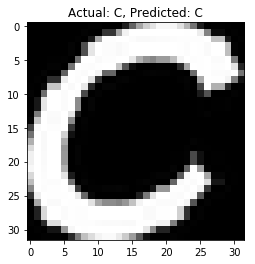

In [0]:
item = next(validation_generator)
actual = get_label(np.argmax(item[1]))
predicted = get_label(model.predict_classes(item[0][0][None]))
plt.title("Actual: " + actual + ", Predicted: " + predicted)
plt.imshow(item[0][0])

In [0]:
!ls -l

total 23008
-rw-r--r--  1 root   root 15070016 Apr 17 10:00 model.h5
-rw-r--r--  1 root   root    13993 Apr 17 08:38 model.png
drwxrwxr-x 12 133040 5000     4096 Aug  9  2011 notMNIST_small
-rw-r--r--  1 root   root  8458043 Oct 27  2011 notMNIST_small.tar.gz
drwxr-xr-x  1 root   root     4096 Apr  4 20:20 sample_data


### Multi-Output CNN

In [0]:
inputs = Input(shape=(784, ))
x = Dense(64, activation='relu')(inputs)
x = Dense(64, activation='relu')(x)
predictions = Dense(10, activation='softmax')(x)

model = Model(input=inputs, outputs=predictions)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train_normalized, y_train_one_hot)

Instructions for updating:
Use tf.cast instead.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("de..., inputs=Tensor("in...)`
  


Epoch 1/1
48000/48000 [==============================] - 7s 137us/step - loss: 0.3047 - acc: 0.9110


In [0]:
inputs = Input(shape=(image_width, image_height, 3))
x = Conv2D(32, (3, 3), padding='same')(inputs)
x = Activation('relu')(x)
x = Conv2D(32, (3, 3))(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(rate=0.25)(x)

x = Conv2D(64, (3, 3), padding='same')(x)
x = Activation('relu')(x)
x = Conv2D(64, (3, 3))(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(rate=0.25)(x)

x = Flatten()(x)
x = Dense(512)(x)
x = Activation('relu')(x)
x = Dropout(rate=0.5)(x)
x = Dense(num_classes)(x)
output1 = Activation('softmax')(x)
output2 = Activation('softmax')(x)

model = Model(inputs=inputs, outputs=[output1, output2])

In [0]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_28 (Conv2D)              (None, 32, 32, 32)   896         input_12[0][0]                   
__________________________________________________________________________________________________
activation_41 (Activation)      (None, 32, 32, 32)   0           conv2d_28[0][0]                  
__________________________________________________________________________________________________
conv2d_29 (Conv2D)              (None, 30, 30, 32)   9248        activation_41[0][0]              
__________________________________________________________________________________________________
activation

In [0]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [0]:
def get_generator_multi_output(generator):
  global invalid_img_count
  while True:
    try:
      data, labels = next(generator)
      yield data, labels, labels
    except:
      invalid_img_count += 1
      pass

In [0]:
next(get_generator_multi_output(train_generator))[2].shape

Exception ignored in: <generator object get_generator_multi_output at 0x7f2485d71780>
RuntimeError: generator ignored GeneratorExit


(32, 10)

In [0]:
invalid_img_count = 0
model.fit_generator(get_generator_multi_output(train_generator), steps_per_epoch=step_size_train)

Epoch 1/1


ValueError: ignored

### Question 1
_What approach did you take in coming up with a solution to this problem?_

**Answer:** 

### Question 2
_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)_

**Answer:**

### Question 3
_How did you train your model? How did you generate your synthetic dataset?_ Include examples of images from the synthetic data you constructed.

**Answer:**

----
## Step 2: Train a Model on a Realistic Dataset
Once you have settled on a good architecture, you can train your model on real data. In particular, the [Street View House Numbers (SVHN)](http://ufldl.stanford.edu/housenumbers/) dataset is a good large-scale dataset collected from house numbers in Google Street View. Training on this more challenging dataset, where the digits are not neatly lined-up and have various skews, fonts and colors, likely means you have to do some hyperparameter exploration to perform well.

### Implementation
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [0]:


### Your code implementation goes here.
### Feel free to use as many code cells as needed.



### Question 4
_Describe how you set up the training and testing data for your model. How does the model perform on a realistic dataset?_

**Answer:**

### Question 5
_What changes did you have to make, if any, to achieve "good" results? Were there any options you explored that made the results worse?_

**Answer:**

### Question 6
_What were your initial and final results with testing on a realistic dataset? Do you believe your model is doing a good enough job at classifying numbers correctly?_

**Answer:**

----
## Step 3: Test a Model on Newly-Captured Images

Take several pictures of numbers that you find around you (at least five), and run them through your classifier on your computer to produce example results. Alternatively (optionally), you can try using OpenCV / SimpleCV / Pygame to capture live images from a webcam and run those through your classifier.

### Implementation
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [0]:


### Your code implementation goes here.
### Feel free to use as many code cells as needed.



### Question 7
_Choose five candidate images of numbers you took from around you and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult?_

**Answer:**

### Question 8
_Is your model able to perform equally well on captured pictures or a live camera stream when compared to testing on the realistic dataset?_

**Answer:**

### Optional: Question 9
_If necessary, provide documentation for how an interface was built for your model to load and classify newly-acquired images._

**Answer:** Leave blank if you did not complete this part.

----
### Step 4: Explore an Improvement for a Model

There are many things you can do once you have the basic classifier in place. One example would be to also localize where the numbers are on the image. The SVHN dataset provides bounding boxes that you can tune to train a localizer. Train a regression loss to the coordinates of the bounding box, and then test it. 

### Implementation
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [0]:


### Your code implementation goes here.
### Feel free to use as many code cells as needed.



### Question 10
_How well does your model localize numbers on the testing set from the realistic dataset? Do your classification results change at all with localization included?_

**Answer:**

### Question 11
_Test the localization function on the images you captured in **Step 3**. Does the model accurately calculate a bounding box for the numbers in the images you found? If you did not use a graphical interface, you may need to investigate the bounding boxes by hand._ Provide an example of the localization created on a captured image.

**Answer:**

----
## Optional Step 5: Build an Application or Program for a Model
Take your project one step further. If you're interested, look to build an Android application or even a more robust Python program that can interface with input images and display the classified numbers and even the bounding boxes. You can for example try to build an augmented reality app by overlaying your answer on the image like the [Word Lens](https://en.wikipedia.org/wiki/Word_Lens) app does.

Loading a TensorFlow model into a camera app on Android is demonstrated in the [TensorFlow Android demo app](https://github.com/tensorflow/tensorflow/tree/master/tensorflow/examples/android), which you can simply modify.

If you decide to explore this optional route, be sure to document your interface and implementation, along with significant results you find. You can see the additional rubric items that you could be evaluated on by [following this link](https://review.udacity.com/#!/rubrics/413/view).

### Optional Implementation
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [0]:


### Your optional code implementation goes here.
### Feel free to use as many code cells as needed.



### Documentation
Provide additional documentation sufficient for detailing the implementation of the Android application or Python program for visualizing the classification of numbers in images. It should be clear how the program or application works. Demonstrations should be provided. 

_Write your documentation here._

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  
**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.